In [122]:
# Imports and Setup
import sys
import os

# Add cmds directory to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'cmds'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import helper functions from cmds/
from portfolio import performanceMetrics, maximumDrawdown, tailMetrics

def calc_summary_statistics_from_equity(equity_df, freq_per_year=252*390, var_quantile=0.05):
    """
    Calculate summary statistics from equity curves DataFrame.
    Uses the SAME formulas as the original RL notebooks:
    - ann_return = (1 + total_return)^(freq_per_year / n_steps) - 1  (compound annual return)
    - ann_vol = std(returns) * sqrt(freq_per_year)
    - sharpe = ann_return / ann_vol
    
    Parameters:
    -----------
    equity_df : DataFrame
        DataFrame with equity curves (account values) for each strategy
    freq_per_year : int
        Number of periods per year (252 days * 390 minutes for US equities minute data)
    var_quantile : float
        Quantile for VaR calculation (default 5%)
    """
    summary = pd.DataFrame(index=equity_df.columns)
    
    # Calculate returns from equity
    returns = equity_df.pct_change().fillna(0.0)
    n_steps = len(equity_df)
    
    for col in equity_df.columns:
        equity = equity_df[col]
        rets = returns[col]
        
        # Total return
        total_return = float(equity.iloc[-1] / equity.iloc[0] - 1.0)
        
        # Annualized return using compound formula (same as original notebooks)
        ann_return = (1.0 + total_return) ** (freq_per_year / n_steps) - 1.0 if n_steps > 1 else np.nan
        
        # Annualized volatility
        ann_vol = float(rets.std() * np.sqrt(freq_per_year))
        
        # Sharpe ratio (same as original notebooks)
        sharpe = float(ann_return / ann_vol) if ann_vol > 0 else np.nan
        
        summary.loc[col, 'Total Return'] = total_return
        summary.loc[col, 'Annualized Return'] = ann_return
        summary.loc[col, 'Annualized Vol'] = ann_vol
        summary.loc[col, 'Sharpe'] = sharpe
        summary.loc[col, 'Min'] = rets.min()
        summary.loc[col, 'Max'] = rets.max()
        summary.loc[col, 'Skewness'] = rets.skew()
        summary.loc[col, 'Excess Kurtosis'] = rets.kurtosis()
        
        # VaR and CVaR
        summary.loc[col, f'Historical VaR ({var_quantile:.2%})'] = rets.quantile(var_quantile)
        cvar_mask = rets <= rets.quantile(var_quantile)
        summary.loc[col, f'Historical CVaR ({var_quantile:.2%})'] = rets[cvar_mask].mean()
        
        # Max Drawdown (same calculation as original notebooks)
        running_max = equity.cummax()
        drawdown = equity / running_max - 1.0
        max_dd = float(drawdown.min())
        
        summary.loc[col, 'Max Drawdown'] = max_dd
        
        # Peak, Bottom, Recovery dates
        dd_end_time = drawdown.idxmin()
        dd_before = drawdown.loc[:dd_end_time]
        zero_dd = dd_before[dd_before == 0.0]
        dd_start_time = zero_dd.index[-1] if not zero_dd.empty else equity_df.index[0]
        
        summary.loc[col, 'Peak'] = dd_start_time
        summary.loc[col, 'Bottom'] = dd_end_time
        
        # Find recovery
        prev_max_val = running_max.loc[:dd_end_time].max()
        post_bottom = equity.loc[dd_end_time:]
        recovery_mask = post_bottom >= prev_max_val
        if recovery_mask.any():
            summary.loc[col, 'Recovery'] = post_bottom[recovery_mask].index.min()
        else:
            summary.loc[col, 'Recovery'] = pd.NaT
    
    return summary

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Define base paths
BASE_PATH = os.path.dirname(os.getcwd())
INITIAL_CAPITAL = 100_000

In [123]:
# Load RL Model Data
# Load ppo_oos_account_value.csv from each RL model variant

# RL-Base
df_base = pd.read_csv(os.path.join(BASE_PATH, 'RL-Base', 'ppo_oos_account_value.csv'), parse_dates=['date'])
df_base = df_base.set_index('date')[['account_value']].rename(columns={'account_value': 'PPO-Base'})

# RL-Base-200k (trained with 200k timesteps)
df_base_200k = pd.read_csv(os.path.join(BASE_PATH, 'RL-Base-200k', 'ppo_oos_account_value.csv'), parse_dates=['date'])
df_base_200k = df_base_200k.set_index('date')[['account_value']].rename(columns={'account_value': 'PPO-Base-200k'})

# RL-LSTM
df_lstm = pd.read_csv(os.path.join(BASE_PATH, 'RL-LSTM', 'ppo_oos_account_value.csv'), parse_dates=['date'])
df_lstm = df_lstm.set_index('date')[['account_value']].rename(columns={'account_value': 'PPO-LSTM'})

# RL-LSTM-Sharpe
df_lstm_sharpe = pd.read_csv(os.path.join(BASE_PATH, 'RL-LSTM-Sharpe', 'ppo_oos_account_value.csv'), parse_dates=['date'])
df_lstm_sharpe = df_lstm_sharpe.set_index('date')[['account_value']].rename(columns={'account_value': 'PPO-LSTM-Sharpe'})

# RL-Sharpe
df_sharpe = pd.read_csv(os.path.join(BASE_PATH, 'RL-Sharpe', 'ppo_oos_account_value.csv'), parse_dates=['date'])
df_sharpe = df_sharpe.set_index('date')[['account_value']].rename(columns={'account_value': 'PPO-Sharpe'})

# Combine RL models in desired order: Base, Base-200k, Sharpe, LSTM, LSTM-Sharpe
rl_equity = df_base.join(df_base_200k, how='outer').join(df_sharpe, how='outer').join(df_lstm, how='outer').join(df_lstm_sharpe, how='outer')
rl_equity.head()

,PPO-Base,PPO-Base-200k,PPO-Sharpe,PPO-LSTM,PPO-LSTM-Sharpe
date,,,,,
2025-10-27 14:51:00,100008.8281,100007.5605,100010.9980,100000.4615,100000.0210
2025-10-27 14:52:00,100007.1687,100006.1471,100004.7612,100000.4236,99999.9136
2025-10-27 14:53:00,100011.1208,100009.8273,100013.2971,100000.4631,99997.1147
2025-10-27 14:54:00,100005.9889,100005.7726,100010.3374,100001.2278,99994.9458
2025-10-27 14:55:00,100000.0627,100001.1713,100008.7781,100001.0403,99985.6853


In [124]:
# Load Baseline Data
# Load equity curves from RL-Base/compare/ directory

compare_path = os.path.join(BASE_PATH, 'RL-Base', 'compare')

# Hold VOO (S&P 500 ETF benchmark)
df_voo = pd.read_csv(os.path.join(compare_path, 'Hold_VOO_equity.csv'), parse_dates=['DateTime'])
df_voo = df_voo.set_index('DateTime').rename(columns={'Hold_VOO': 'Hold VOO'})

# Buy & Hold Equal Weight
df_equal = pd.read_csv(os.path.join(compare_path, 'Buy_Hold_Equal_equity.csv'), parse_dates=['DateTime'])
df_equal = df_equal.set_index('DateTime').rename(columns={'Buy_Hold_Equal': 'Buy & Hold Equal'})

# Create Simple Momentum Strategy
# Strategy: Go long if 20-period return is positive, go flat/cash otherwise
# Uses the equal weight portfolio as the underlying

MOMENTUM_LOOKBACK = 20  # 20-minute lookback for momentum signal

# Calculate returns from the equal weight portfolio
equal_returns = df_equal['Buy & Hold Equal'].pct_change()

# Generate momentum signal: 1 if positive momentum, 0 otherwise
momentum_signal = (equal_returns.rolling(window=MOMENTUM_LOOKBACK).mean() > 0).astype(int).shift(1)

# Apply momentum signal to equal weight returns
momentum_returns = equal_returns * momentum_signal

# Build equity curve from momentum strategy returns
momentum_equity = (1 + momentum_returns.fillna(0)).cumprod() * INITIAL_CAPITAL
df_momentum = momentum_equity.to_frame('Momentum')

# Combine baselines (VOO, Equal Weight, and Momentum)
baseline_equity = df_voo.join(df_equal, how='outer').join(df_momentum, how='outer')
baseline_equity.head()

,Hold VOO,Buy & Hold Equal,Momentum
DateTime,,,
2025-10-27 14:50:00,100000.0000,100000.0000,100000.0000
2025-10-27 14:51:00,99988.0860,100003.7800,100000.0000
2025-10-27 14:52:00,99988.0860,99997.5400,100000.0000
2025-10-27 14:53:00,99992.0550,100007.6600,100000.0000
2025-10-27 14:54:00,99996.0300,100008.7660,100000.0000


In [125]:
# Merge All Equity Curves and Compute Returns

# Merge RL models and baselines
all_equity = rl_equity.join(baseline_equity, how='outer')

# Forward fill any missing values and drop remaining NaNs
all_equity = all_equity.ffill().dropna()

# Ensure unique index (remove any duplicate timestamps)
all_equity = all_equity[~all_equity.index.duplicated(keep='first')]

# Compute period returns from account values
returns = all_equity.pct_change().dropna()

# Define strategy groupings for visualization
rl_strategies = ['PPO-Base', 'PPO-Base-200k', 'PPO-Sharpe', 'PPO-LSTM', 'PPO-LSTM-Sharpe']
baseline_strategies = ['Hold VOO', 'Buy & Hold Equal', 'Momentum']
all_strategies = rl_strategies + baseline_strategies

# Reorder all_equity columns to match desired order
all_equity = all_equity[all_strategies]

# Recompute returns with correct column order
returns = all_equity.pct_change().dropna()

# Display summary
display(all_equity.tail())

,PPO-Base,PPO-Base-200k,PPO-Sharpe,PPO-LSTM,PPO-LSTM-Sharpe,Hold VOO,Buy & Hold Equal,Momentum
2025-12-03 15:55:00,101242.5106,100865.6013,100226.5098,100766.7371,101807.2590,99970.5860,99815.4450,99456.7684
2025-12-03 15:56:00,101237.6993,100861.7934,100232.9205,100752.1594,101793.8237,99967.4140,99806.4100,99456.7684
2025-12-03 15:57:00,101258.3470,100874.5268,100241.0367,100753.4031,101805.4821,99953.1000,99817.0860,99456.7684
2025-12-03 15:58:00,101265.0292,100879.2824,100245.0675,100754.0120,101802.8605,99961.0500,99820.8400,99456.7684
2025-12-03 15:59:00,101263.3485,100878.1507,100247.9015,100755.6872,101797.3845,99967.4140,99822.4450,99456.7684


In [126]:
# Performance Statistics Table
# Using the SAME formulas as the original RL notebooks for consistency
# Data is minute-level: 252 trading days * 390 minutes per day = 98,280 periods per year

FREQ_PER_YEAR = 252 * 390  # Trading minutes per year (same as original notebooks)

# Calculate performance metrics using equity curves (same method as original notebooks)
perf_stats = calc_summary_statistics_from_equity(all_equity, freq_per_year=FREQ_PER_YEAR, var_quantile=0.05)

# Reorder rows to match desired order
perf_stats = perf_stats.reindex(all_strategies)

# Select key columns for display
display_cols = ['Total Return', 'Annualized Return', 'Annualized Vol', 'Sharpe', 'Max Drawdown', 
                'Historical VaR (5.00%)', 'Historical CVaR (5.00%)', 'Min', 'Max']
perf_stats_display = perf_stats[display_cols].copy()

# Style and display the table
# Style and display the table
perf_stats_styled = perf_stats_display.style.format({
    'Total Return': '{:.4%}',
    'Annualized Return': '{:.4%}',
    'Annualized Vol': '{:.4%}',
    'Sharpe': '{:.2f}',
    'Max Drawdown': '{:.4%}',
    'Historical VaR (5.00%)': '{:.6f}',
    'Historical CVaR (5.00%)': '{:.6f}',
    'Min': '{:.6f}',
    'Max': '{:.6f}'
}).background_gradient(cmap='RdYlGn', subset=['Sharpe'])

display(perf_stats_styled)

,Total Return,Annualized Return,Annualized Vol,Sharpe,Max Drawdown,Historical VaR (5.00%),Historical CVaR (5.00%),Min,Max
PPO-Base,1.2544%,13.1188%,5.6561%,2.32,-1.1542%,-0.000161,-0.000287,-0.005089,0.006244
PPO-Base-200k,0.8705%,8.9488%,4.9190%,1.82,-1.1448%,-0.000132,-0.000244,-0.004881,0.005989
PPO-Sharpe,0.2369%,2.3671%,4.5918%,0.52,-1.1816%,-0.000164,-0.000279,-0.004525,0.004057
PPO-LSTM,0.7552%,7.7236%,4.9139%,1.57,-1.4984%,-0.000170,-0.000281,-0.005395,0.003395
PPO-LSTM-Sharpe,1.7974%,19.2618%,5.5148%,3.49,-1.1199%,-0.000191,-0.000304,-0.004650,0.005872
Hold VOO,-0.0207%,-0.2042%,15.5699%,-0.01,-5.5659%,-0.000625,-0.001027,-0.010471,0.015890
Buy & Hold Equal,-0.1813%,-1.7787%,8.5789%,-0.21,-3.0316%,-0.000308,-0.000524,-0.008504,0.009019
Momentum,-0.5432%,-5.2438%,6.1395%,-0.85,-2.7394%,-0.000201,-0.000379,-0.008504,0.009019


In [127]:
# Tail Risk and Drawdown Statistics Table
# Using pmh.calc_summary_statistics - extract additional risk metrics

# Select tail risk columns from perf_stats (already calculated above)
tail_cols = ['Skewness', 'Excess Kurtosis', 'Historical VaR (5.00%)', 'Historical CVaR (5.00%)', 
             'Max Drawdown', 'Peak', 'Bottom', 'Recovery']
tail_display = perf_stats[tail_cols].copy()

# Style and display the table
tail_styled = tail_display.style.format({
    'Skewness': '{:.4f}',
    'Excess Kurtosis': '{:.4f}',
    'Historical VaR (5.00%)': '{:.6f}',
    'Historical CVaR (5.00%)': '{:.6f}',
    'Max Drawdown': '{:.4%}',
    'Peak': lambda x: str(x)[:16] if pd.notna(x) else 'N/A',
    'Bottom': lambda x: str(x)[:16] if pd.notna(x) else 'N/A',
    'Recovery': lambda x: str(x)[:16] if pd.notna(x) else 'Not Recovered'
}).background_gradient(cmap='RdYlGn_r', subset=['Max Drawdown', 'Historical VaR (5.00%)', 'Historical CVaR (5.00%)'])

display(tail_styled)

,Skewness,Excess Kurtosis,Historical VaR (5.00%),Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Recovery
PPO-Base,2.3767,427.3212,-0.000161,-0.000287,-1.1542%,2025-11-13 09:37,2025-11-25 15:53,Not Recovered
PPO-Base-200k,2.2600,516.7842,-0.000132,-0.000244,-1.1448%,2025-11-13 09:37,2025-11-25 15:53,Not Recovered
PPO-Sharpe,-1.3575,267.9527,-0.000164,-0.000279,-1.1816%,2025-11-13 09:36,2025-11-20 10:37,Not Recovered
PPO-LSTM,-1.6852,280.3154,-0.000170,-0.000281,-1.4984%,2025-11-12 12:40,2025-11-17 15:01,2025-11-25 10:08
PPO-LSTM-Sharpe,5.9656,292.0022,-0.000191,-0.000304,-1.1199%,2025-11-21 11:05,2025-11-26 15:12,Not Recovered
Hold VOO,2.4712,178.4015,-0.000625,-0.001027,-5.5659%,2025-10-29 09:59,2025-11-21 11:05,Not Recovered
Buy & Hold Equal,-1.6418,342.9106,-0.000308,-0.000524,-3.0316%,2025-11-12 13:39,2025-11-21 10:41,Not Recovered
Momentum,-1.2437,872.5999,-0.000201,-0.000379,-2.7394%,2025-10-27 15:10,2025-11-06 12:39,Not Recovered


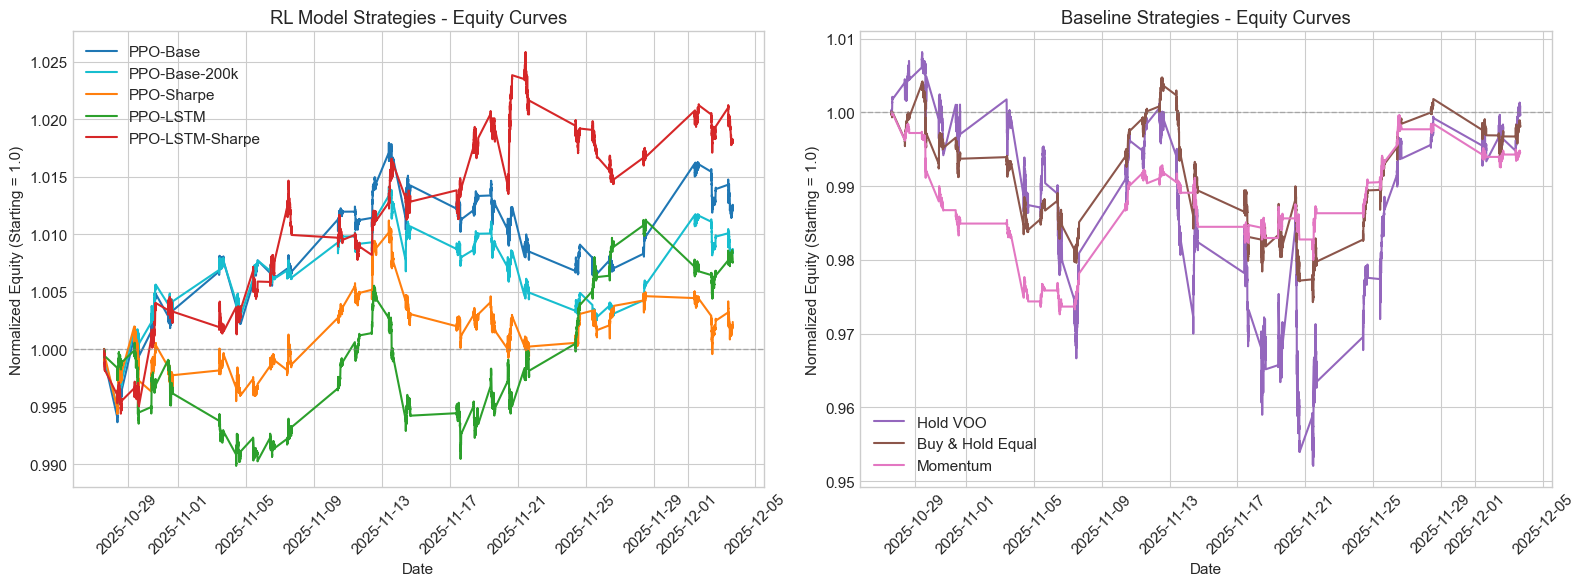

In [128]:
# Cumulative Returns / Equity Curve Plot
# Normalize equity curves to start at 1.0 for comparison

normalized_equity = all_equity / all_equity.iloc[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: RL Strategies
ax1 = axes[0]
colors_rl = ['#1f77b4', '#17becf', '#ff7f0e', '#2ca02c', '#d62728']
for i, col in enumerate(rl_strategies):
    ax1.plot(normalized_equity.index, normalized_equity[col], label=col, color=colors_rl[i], linewidth=1.5)
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Equity (Starting = 1.0)')
ax1.set_title('RL Model Strategies - Equity Curves')
ax1.legend(loc='best')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Baseline Strategies
ax2 = axes[1]
colors_base = ['#9467bd', '#8c564b', '#e377c2']
for i, col in enumerate(baseline_strategies):
    ax2.plot(normalized_equity.index, normalized_equity[col], label=col, color=colors_base[i], linewidth=1.5)
ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Equity (Starting = 1.0)')
ax2.set_title('Baseline Strategies - Equity Curves')
ax2.legend(loc='best')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), 'equity_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

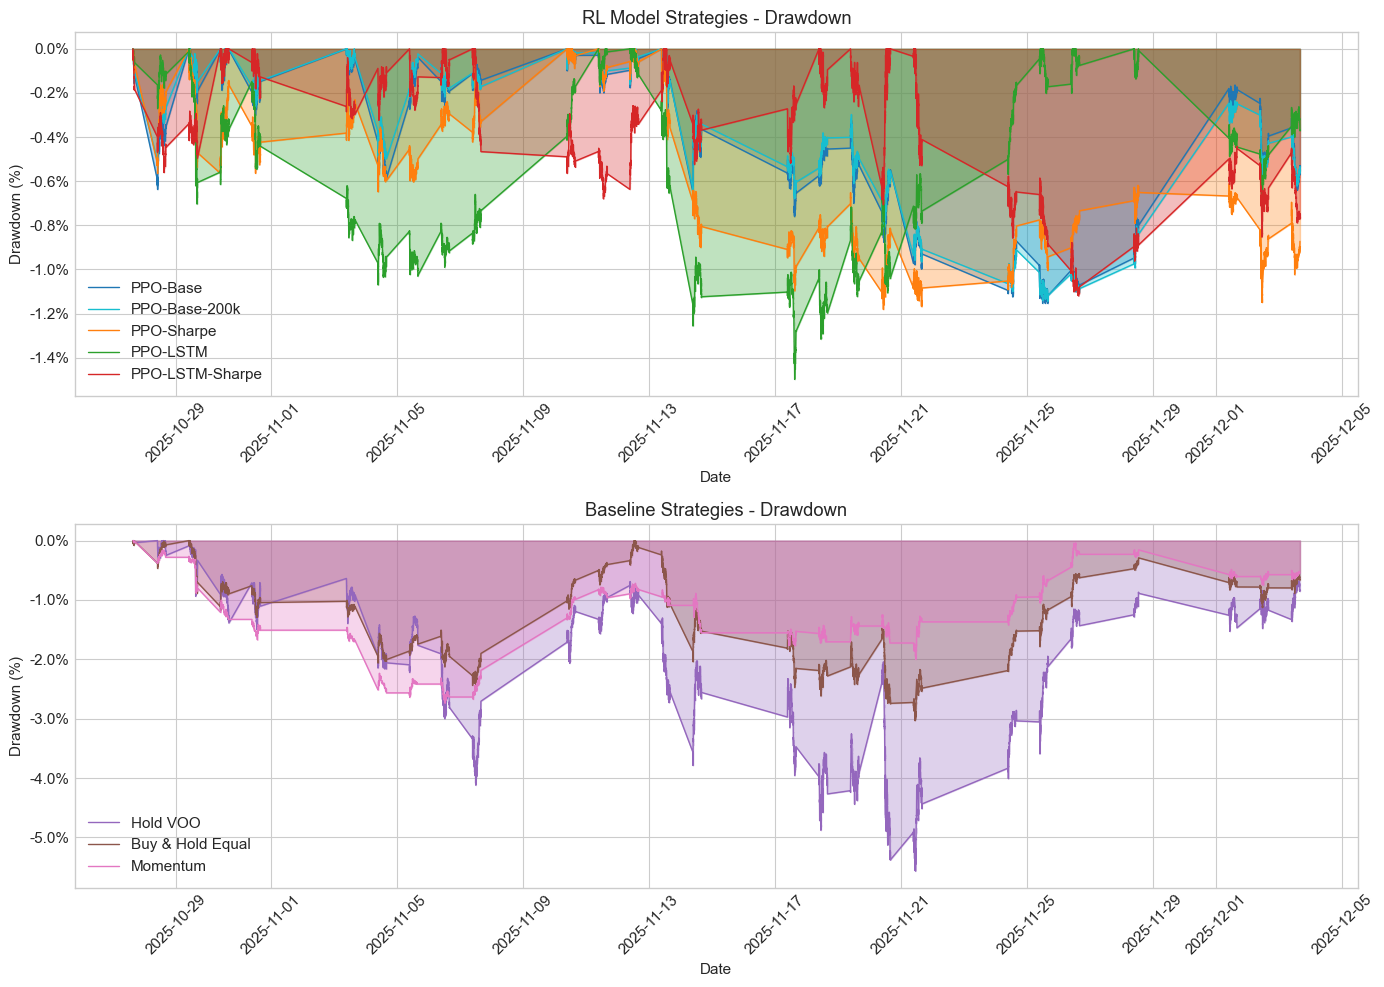

In [129]:
# Drawdown Time Series Plot
# Calculate drawdown as percentage below running maximum

def calculate_drawdown(equity_series):
    """Calculate drawdown series from equity curve"""
    rolling_max = equity_series.cummax()
    drawdown = (equity_series - rolling_max) / rolling_max
    return drawdown

# Calculate drawdowns for all strategies
drawdowns = all_equity.apply(calculate_drawdown)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: RL Strategies Drawdown
ax1 = axes[0]
colors_rl = ['#1f77b4', '#17becf', '#ff7f0e', '#2ca02c', '#d62728']
for i, col in enumerate(rl_strategies):
    ax1.fill_between(drawdowns.index, drawdowns[col], 0, alpha=0.3, color=colors_rl[i])
    ax1.plot(drawdowns.index, drawdowns[col], label=col, color=colors_rl[i], linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Drawdown (%)')
ax1.set_title('RL Model Strategies - Drawdown')
ax1.legend(loc='lower left')
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Plot 2: Baseline Strategies Drawdown
ax2 = axes[1]
colors_base = ['#9467bd', '#8c564b', '#e377c2']
for i, col in enumerate(baseline_strategies):
    ax2.fill_between(drawdowns.index, drawdowns[col], 0, alpha=0.3, color=colors_base[i])
    ax2.plot(drawdowns.index, drawdowns[col], label=col, color=colors_base[i], linewidth=1)
ax2.set_xlabel('Date')
ax2.set_ylabel('Drawdown (%)')
ax2.set_title('Baseline Strategies - Drawdown')
ax2.legend(loc='lower left')
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), 'drawdowns.png'), dpi=150, bbox_inches='tight')
plt.show()

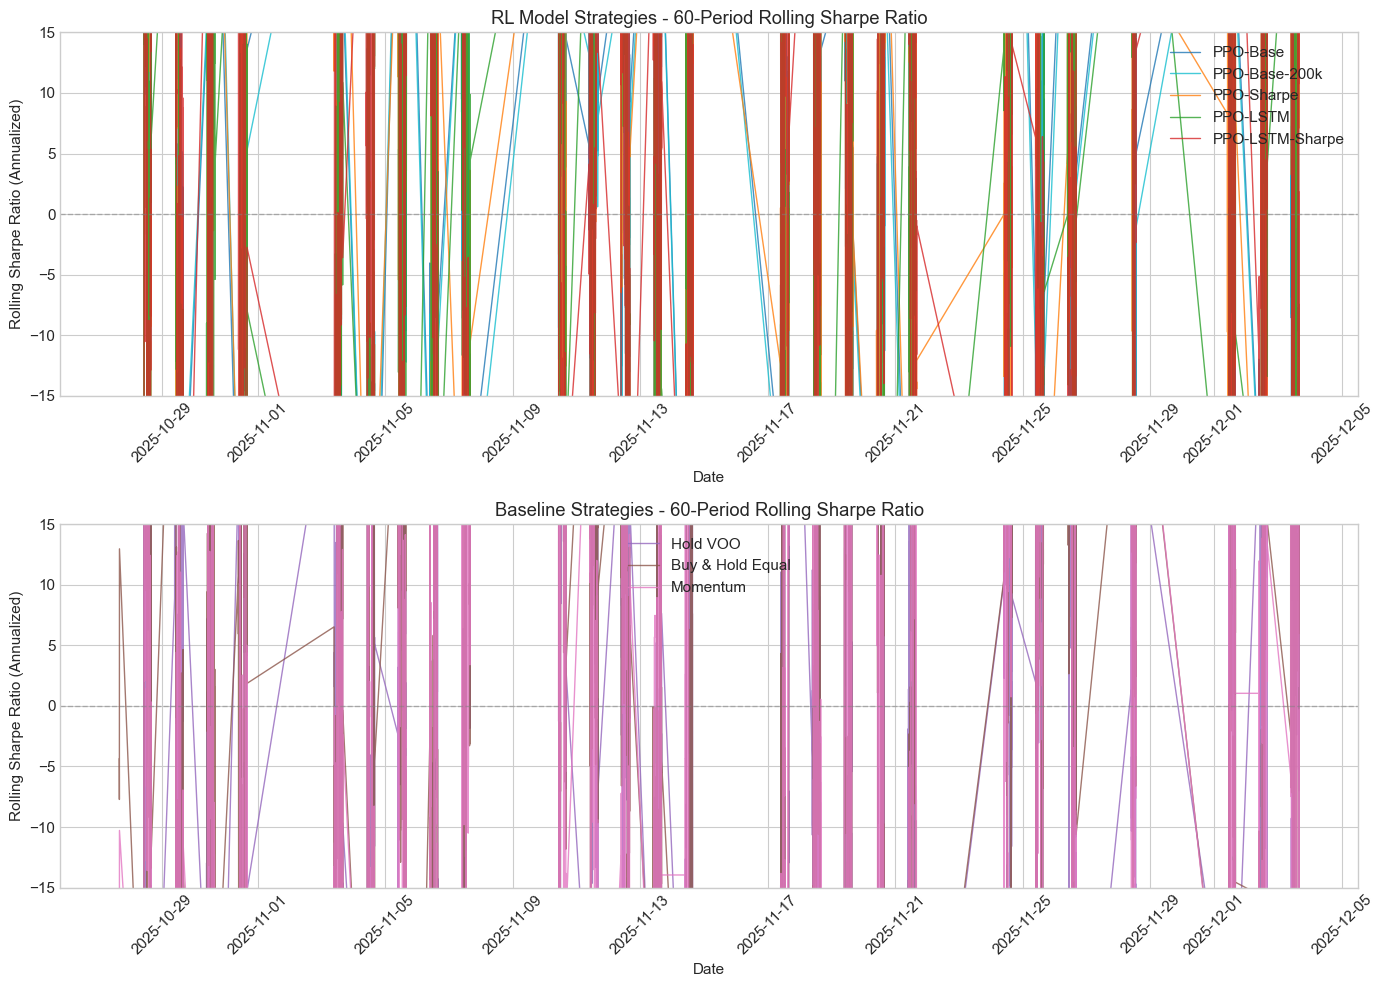

In [130]:
# Rolling Sharpe Ratio Plot
# Calculate 60-period rolling Sharpe ratio (annualized)

ROLLING_WINDOW = 60  # 60 minute rolling window

def rolling_sharpe(returns_series, window=60, annualization=MINUTES_PER_YEAR):
    """Calculate rolling Sharpe ratio"""
    rolling_mean = returns_series.rolling(window=window).mean()
    rolling_std = returns_series.rolling(window=window).std()
    rolling_sharpe = (rolling_mean / rolling_std) * np.sqrt(annualization)
    return rolling_sharpe

# Calculate rolling Sharpe for all strategies
rolling_sharpes = returns.apply(lambda x: rolling_sharpe(x, window=ROLLING_WINDOW))

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: RL Strategies Rolling Sharpe
ax1 = axes[0]
colors_rl = ['#1f77b4', '#17becf', '#ff7f0e', '#2ca02c', '#d62728']
for i, col in enumerate(rl_strategies):
    ax1.plot(rolling_sharpes.index, rolling_sharpes[col], label=col, color=colors_rl[i], linewidth=1, alpha=0.8)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Sharpe Ratio (Annualized)')
ax1.set_title(f'RL Model Strategies - {ROLLING_WINDOW}-Period Rolling Sharpe Ratio')
ax1.legend(loc='best')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(-15, 15)

# Plot 2: Baseline Strategies Rolling Sharpe
ax2 = axes[1]
colors_base = ['#9467bd', '#8c564b', '#e377c2']
for i, col in enumerate(baseline_strategies):
    ax2.plot(rolling_sharpes.index, rolling_sharpes[col], label=col, color=colors_base[i], linewidth=1, alpha=0.8)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Date')
ax2.set_ylabel('Rolling Sharpe Ratio (Annualized)')
ax2.set_title(f'Baseline Strategies - {ROLLING_WINDOW}-Period Rolling Sharpe Ratio')
ax2.legend(loc='best')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(-15, 15)

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), 'rolling_sharpe.png'), dpi=150, bbox_inches='tight')
plt.show()

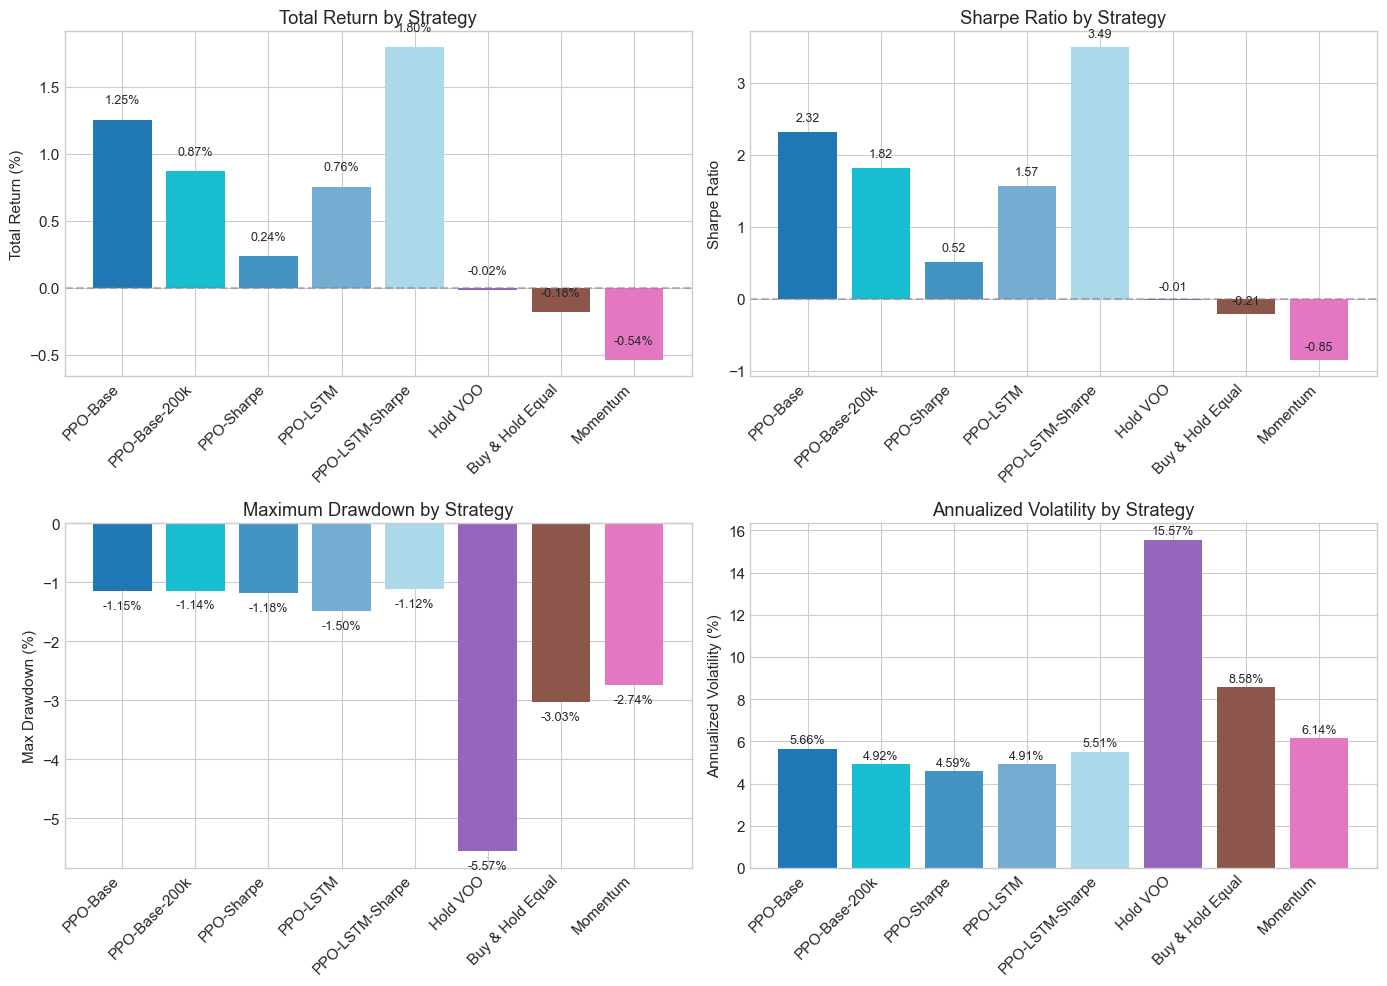

In [131]:
# Summary Comparison Bar Charts
# Compare key metrics across all strategies

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Color mapping: RL strategies in blue tones, baselines in other colors
colors = ['#1f77b4', '#17becf', '#4393c3', '#74add1', '#abd9e9', '#9467bd', '#8c564b', '#e377c2']

# Prepare data for bar charts
strategies = all_strategies
x_pos = np.arange(len(strategies))

# Calculate total returns from equity curves
total_returns_pct = ((all_equity.iloc[-1] / all_equity.iloc[0]) - 1) * 100

# Chart 1: Total Return (%)
ax1 = axes[0, 0]
total_returns = [total_returns_pct[s] for s in strategies]
bars1 = ax1.bar(x_pos, total_returns, color=colors)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(strategies, rotation=45, ha='right')
ax1.set_ylabel('Total Return (%)')
ax1.set_title('Total Return by Strategy')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars1, total_returns):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}%', 
             ha='center', va='bottom', fontsize=9)

# Chart 2: Sharpe Ratio (using same formula as original notebooks)
ax2 = axes[0, 1]
sharpes = [perf_stats.loc[s, 'Sharpe'] for s in strategies]
bars2 = ax2.bar(x_pos, sharpes, color=colors)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(strategies, rotation=45, ha='right')
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('Sharpe Ratio by Strategy')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars2, sharpes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}', 
             ha='center', va='bottom', fontsize=9)

# Chart 3: Max Drawdown (%)
ax3 = axes[1, 0]
max_dds = [perf_stats.loc[s, 'Max Drawdown'] * 100 for s in strategies]
bars3 = ax3.bar(x_pos, max_dds, color=colors)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(strategies, rotation=45, ha='right')
ax3.set_ylabel('Max Drawdown (%)')
ax3.set_title('Maximum Drawdown by Strategy')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars3, max_dds):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.15, f'{val:.2f}%', 
             ha='center', va='top', fontsize=9)

# Chart 4: Annualized Volatility
ax4 = axes[1, 1]
vols = [perf_stats.loc[s, 'Annualized Vol'] * 100 for s in strategies]
bars4 = ax4.bar(x_pos, vols, color=colors)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(strategies, rotation=45, ha='right')
ax4.set_ylabel('Annualized Volatility (%)')
ax4.set_title('Annualized Volatility by Strategy')
for bar, val in zip(bars4, vols):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}%', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), 'metrics_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()